## Small-Signal Stability Index Python Script

### <br>NYPA Machine Learning Project
### ALSET Lab Research Group
### 07/23/2020

<p style='text-align: justify;'> <i><br>Electrical Power Systems are complex dynamical systems that are in constant tug of war between generation and load. In a simplistic way, both ends are constantly being tracked in order to balance the generation side to the load side and reach a stable operating margin. Since load is a stochastic parameter, there is a certain randomness that turns power system stability into a challenging and important task in power system analysis.
There are numerous stability indices that have been proposed throughout the years utilizing a steady state formulation. These formulations require knowledge of the system’s admittance matrix (YM), generator’s active power injection/consumption and the load’s active and reactive power. Alongside these requirements, there are also modeling limitations and simplifications that do not account for the dynamics of the system. 
<br>For real-time power system stability assessment, these static methods are not helpful, with the exception in planning phases. That being said, the proposition in [1] is a step forward into developing an online stability index generator that can be used to help system operator’s in decision making. The development of the small signal stability assessment tool comes from an estimation of the eigenvalues of the system using time-series data from dynamic simulations. 
<br>The stability index is calculated based on three layers of information:
   
* 1st layer - A scalar (positive or negative) that grades the overall damping ratio of all the modes.
* 2nd layer - A vector that points which pre-defined damping ratios were violated.
* 3rd layer - A matrix that has more information about each mode’s damping condition.


#### <br>Algorithm Steps
Figure shown below are the steps that the signal undergoes to finally generate the small-signal stability indices.<br></p>
    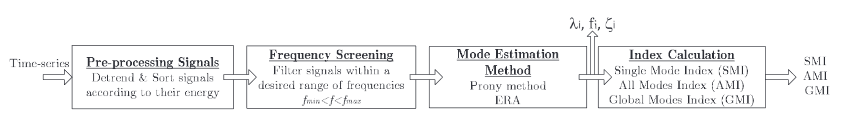
 
### <br>References:

[1] Sevilla, F. R. S., & Vanfretti, L. (2014, July). A small-signal stability index for power system dynamic impact assessment using time-domain simulations. In 2014 IEEE PES General Meeting| Conference & Exposition (pp. 1-5). IEEE.
    



### Step 01 - Preprocessing the Signal

<p style='text-align: justify;'><i><br>Time-series data coming from dynamic simulations provide useful information that can be used to determine some aspects of the system. Before estimating the modes, we must first capture the signals that have the highest oscillation content, which is done by calculating the energy of the signals. We have the active power transfer as data, therefore we can determine the energy by simply taking the integral of the active power transfer per line.
The equation is given by:<br>

\begin{equation}
\label{Preprocessing}
    \hat{y}(t)=y(t)-y_{\operatorname{mean}}(t), \quad E(t)=\int_{-\infty}^{\infty}|\hat{y}(t)|^{2} d t
\end{equation}
    
This step is done on the “test_filter” function below using the variance formulation. Variance measures how far a set of values are far from their average and is expressed as:<br>
    
\begin{equation}    
\operatorname{Var}(x)=\frac{1}{N} \sum_{i=1}^{N}\left(x_{i}-\mu\right)^{2}
\end{equation}
    
<p style='text-align: justify;'>where $N$ is the total number of samples, $x_i$ is the i-th element and $\mu$  is the average of the total number of samples. Comparing equations above, you notice that both express the same concept with the exception of $(1/N)$ term present in the variance formulation, which in our case does not impact the outcome of the simulation.
“test_filter” fucntion , which can be found below, sorts the input signal according to the variance. The signals with a threshold lower than a specific value are removed. 
<br><br>The script has the following configuration:</p>
    
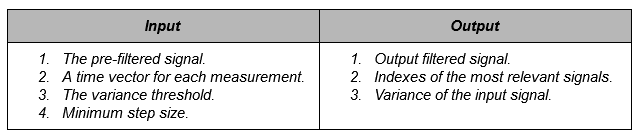



### Empirical Mode Decomposition

<p style='text-align: justify;'> <i><br> The empirical Mode Decomposition is a numerical method used in signal processing to determine intrinsic modes that combined can recreate the original signal.

In [1]:
def test_filter(sig,t,var_thr,step_min):
    '''
    Filter signal Y based on variance. The signals with threshold lower than Thr are removed. 
    The time vector T is required, which has variable step size. The output of the function are:
    Yh- Output signal after filter
    IDX- indexes of the most relevant signals
    VAR-Variance of signals Y.

    If no oscillation is detected, the function gives empty matrices.
    
    '''
    
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    from PyEMD import EMD
    
    nL = len(sig[0])
    ts = t
    trshold = var_thr
    tsmin = step_min
    
    double_dif = np.diff(np.diff(sig[:,0]),axis = 0) # The double_dif array is the double sequenced difference of the elements
    std_dd = np.std(double_dif)
    
    if double_dif[0] > std_dd:
        double_dif = np.delete(double_dif, [0,1])
    elif double_dif[-1] > std_dd:
        double_dif = np.delete(double_dif, [-1])
    
    loc_peak = np.where(abs(double_dif) > std_dd) # Position of the peaks in the sequenced difference array
    n_pk = len(loc_peak[0])
    print("The location of the peaks are {} and the length of the array is {}.".format(loc_peak[0], len(loc_peak[0])))
    print("The last element of the loc_peak array is: ", loc_peak[0][-1])
    
    if (len(loc_peak[0]) % 2) == 0:
        new_time = ts[loc_peak[0][-1]+2::]
        new_signal = sig[loc_peak[0][-1]+2::]    
    elif n_pk == 0:
        new_time = ts
        new_signal = sig
        
    
    dt0 = np.diff(new_time, axis = 0)
    gg=dt0.size
    timex = pd.DataFrame(); signalx = pd.DataFrame(); dt0x = pd.DataFrame()
    
    flag_EDM = input('Would you like to run the filtering process with EDM? [Y/N]:')
    
    j0 = 0
    for k in range(gg):
        if dt0[k] >= tsmin:
            dt0x.loc[j0,0] = dt0[k]
            timex.loc[j0,0] = new_time[k]
            signalx[k] = (new_signal[k,:])
            j0 = j0 + 1
            
    dt0x = dt0x.to_numpy(); timex = timex.to_numpy(); signalx = np.transpose(signalx.to_numpy())  # Converting to numpy array
           
    signalx0 = pd.DataFrame(); osc_signal=pd.DataFrame(); var_s = pd.DataFrame()
    
    for k in range(nL):
            if flag_EDM == 'N' or flag_EDM == 'n':
                signalx0[k] = (signalx[:,k] - np.mean(signalx[:,k])).tolist()
            elif flag_EDM == 'Y':
                emd = EMD()
                emd.emd(signalx[:,k])
                imfs, res = emd.get_imfs_and_residue()
                plt.figure(56)
                plt.plot(imfs)
                plt.xlabel('imfs')
                signalx0[k] = np.transpose(imfs[0,:])          # Detrended signal
  
     
    signalx0 = signalx0.to_numpy()
    ydh = np.concatenate((timex, signalx0), axis=1)            # Array containing the time component and the signal
    sig_var = np.transpose(np.var(signalx0,0))
    sig_std = np.transpose(np.std(signalx0,0))
    
    var_sort = np.sort(sig_var)
    var_sort_desc = var_sort[::-1]
    s_idx = np.argsort(sig_var)
    s_idx_desc = s_idx[::-1] 
    
    std_sort = np.sort(sig_std)
    std_sort_desc = std_sort[::-1]
    std_idx = np.argsort(sig_std)
    std_idx_desc = std_idx[::-1] 
    
    nL0 = len(var_sort_desc)
    vA = np.max(var_sort_desc)
    var_sort0 = var_sort_desc/vA
    
    for i in range(nL):
        if var_sort0[i] >= trshold:
            osc_signal.loc[i,0] = s_idx_desc[i]
            var_s.loc[i,0] = var_sort_desc[i]
   
    osc_signal = osc_signal.to_numpy()
    var_s = var_s.to_numpy()
    
    yh = sig[:,np.transpose(osc_signal.astype(int))].reshape(len(sig),len(np.transpose(osc_signal.astype(int))[0]))
    
    return yh, osc_signal, var_s, ydh

### Step 02 - Mode Estimation Method

<br><i>Prony analysis is an extended version of the Fourier analysis where you can estimate the frequency, damping component, and the relative phase of modal components present in a signal. Prony method estimates a discrete linear prediction model that fits the records [2].
Suppose that you have a system that is affected by a stimulus and once the disturbance is removed, the output response decays in the form:<br>
    
\begin{equation}
\dot{x} = Ax
\end{equation}

where x are the states of the system and A is the dynamics of the differential equation.
The solution of (3) can be determined by the eigenvalues and right and left eigenvectors as follows:<br>

\begin{equation}
\begin{aligned} x(t) &=\sum_{i=1}^{n}\left(q_{i}^{T} x_{0}\right) p_{i} \exp \left(\lambda_{i} t\right) \\ &=\sum_{i=1}^{n} R_{i} x_{0} \exp \left(\lambda_{i} t\right) \end{aligned}
\end{equation}
    
where $\lambda_i$, $p_i$, $q_i$ are respectively the eigenvalues,and the right and left eigenvectors from matrix A. The idea then is to estimate the exponential terms in (4) so that we can determine the best fitting function.<br>
    
#### <br>Prony Python Script
    
The original script was written by D. Trudnowski in 1999 and was adapted to fulfill the requirements of this project. “pronyitesla” script has the following configuration:<br>
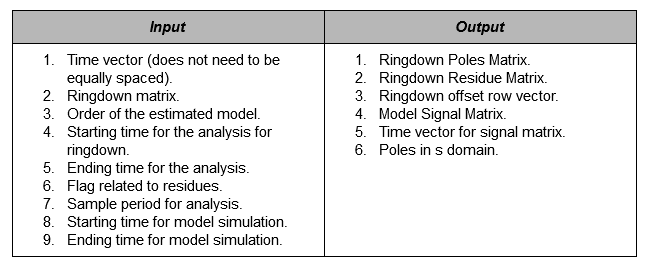

#### <br>Prony Python Script Variables
* acoef: is the A matrix.
* zPoles: are the poles in z domain.
* sPoles: are the poles in s domain.
* Res: residue matrix that consists of the product of the right and left eigenvectors. The residue matrix is called as such because it is linked to the exponential part of (4).
* E: is the energy described in equation (1)
* x: sorted energy array from the filtered signal.
* ii: is the index from the sorted energy array.
* R: rearranged Res matrix following the ii indexing.
* P: rearranged sPoles matrix following the ii indexing.
* that: is the time vector used to plot the Prony output.
* yhat: is the Prony output regarding the pre-defined and filtered signal.

 


In [2]:
def pronyitesla(t,y,XX,tstart,tend,T,shift,tstplot,tedplot,plotFlag):
    
    # %[model]=pronyanalysis(t,y,n,tstart,tend,T,shift,tstplot,tedplot,plotFlag);
    # %Prony analysis program for fitting to a ringdown
    # % Inputs:
    # %   t = time vector (does not need to be equally spaced) -- column vector
    # %       t(1) is assumed to be 0; if not, all time variables are shifted by t(1).
    # %   y = ringdown matrix of order N by NChan corresponding to t, each column is a different signal
    # %   n = order of the estimated model
    # %   tstart = row vector of order 1 by NChan.  tstart(k) is the starting
    # %            time for analysis for y(:,k).
    # %   tend = ending times for analysis (same dimension as tstart)
    # %   shift = flag; if shift = 1, residues are shifted to t = 0.
    # %           If the data is noisy, reccomend shift = 0.
    # %   T = sample period for analysis
    # %   tsttplot = starting time for model simulation
    # %   tedplot = ending time for model simulation
    # %   plotFlag = if = 1, plot results
    # % Outputs (structured array):
    # %   model.Poles = ringdown pole matrix -- column k is for column k of y
    # %   model.Res = ringdown residue matrix
    # %   model.K = ringdown offset row vector
    # %   model.yhat = model signal matrix
    # %   model.that = time vector for yhat (starts at tstart)
    # %
    # % NOTE: It is reccomended that the N/(1+NChan) < 200, where
    # %       N = total number of data points in y to be analyzed, and
    # %       NChan = number of columns in y. 
    
    # % Written by D. Trudnowski, 1999.
    # % Last update, D. Trudnowski, 2005.
    
    # % 1.0 Setup
    
    # %Basic error checks 
    
 
    
    import sys
    import numpy as np
    import math
    import pandas as pd
    import numpy.linalg as lin
    import matplotlib.pyplot as plt
    
    #from scipy.interpolate import CubicSpline
    from scipy import interpolate
    # from scipy.interpolate import UnivariateSpline
    
    # -----------------------------------------------------------------------------------------------------
    # ------------------------------------ BASIC ERROR CHECKS ---------------------------------------------
    # -----------------------------------------------------------------------------------------------------
    
    if ((len(y[0])) != (len(tstart[0]))) or ((len(y[0])) != (len(tend[0]))):
        sys.exit('Dimension error in y, tstart, tend.')
    if ((len(tstart)) != 1) or ((len(tend)) != 1):
        sys.exit('Dimension error in tstart or tend.')
    if (T <= 0) or (tstplot >= tedplot) or (np.max(t) < np.max(np.transpose(tend))) or (np.min(t) > np.min(np.transpose(tstart))):
        sys.exit('Data Error.')
    if (len(t) != len(y)) or (len(t[0]) != 1):
        sys.exit('Dimension error in y or t')
    
    # -----------------------------------------------------------------------------------------------------
    # ----------------------------------- DATA PARAMETERS -------------------------------------------------
    # -----------------------------------------------------------------------------------------------------
        
    NChannels = len(y[0])
    
    # -----------------------------------------------------------------------------------------------------
    # ----------------------------------- SHIFT TIME PARAMETERS -------------------------------------------
    # -----------------------------------------------------------------------------------------------------
    
    tstart = tstart-t[0]                                    # OK!    
    tend = tend-t[0]                                        # OK!
    tstplot = tstplot-t[0]                                  # OK!
    tedplot = tedplot-t[0]                                  # OK!
    t = t-t[0]                                              # OK!
    
    # -----------------------------------------------------------------------------------------------------
    # ---------------------------- Set up analysis data and calculate offset ------------------------------
    # -----------------------------------------------------------------------------------------------------
        
    tanalysis = T*np.transpose(np.array(range(math.ceil(np.max(np.transpose(tend))/T)+2)))     # OK!
    Nstart = np.zeros([1,NChannels])                                                           # OK!
    #Nstart = Nstart.reshape(-1,1)
    Nend = np.zeros([1,NChannels])                                                             # OK!
    #Nend = Nend.reshape(-1,1)
    yanal = np.zeros([len(tanalysis),NChannels])                                               # OK!
    #K = np.zeros([1,NChannels])
    
    # for k=1:NChannels
    #     Nstart(k) = floor(tstart(k)/T)+1;
    #     Nend(k) = ceil(tend(k)/T)+1;
    #     yanal(:,k) = spline(t,y(:,k),tanalysis);
    #     K(1,k) = mean(yanal(Nstart(k):Nend(k),k));
    #     yanal(:,k) = yanal(:,k)-K(k);
    # end
    
    
    K = np.zeros([1,NChannels])                                                                  # OK!
    
    for i in range(NChannels):
        Nstart[0,i] = math.floor(tstart[:,i]/T)
        Nend[0,i] = math.ceil(tend[:,i]/T)+1
        #yanal[:,i] = UnivariateSpline(t.flatten(), y[:,i].flatten())
        #spl = CubicSpline(t.flatten(), y[:,i].flatten())
        spl = interpolate.splrep(t.flatten(), y[:,i].flatten())
        #yanal[:,i] = spl(tanalysis)
        yanal[:,i] = interpolate.splev(tanalysis, spl)
        K[0,i] = np.mean(yanal[int(Nstart[0,i]):int((Nend[0,i])),i])
        yanal[:,i] = yanal[:,i] - K[0,i]
        
        
    # -----------------------------------------------------------------------------------------------------
    # --------------------------------------- FIND MODEL ORDER --------------------------------------------
    # ----------------------------------------------------------------------------------------------------- 
    
    # NdataPoints = Nend-Nstart+1; %Number of data points used for analysis on each channel
    # Ntotal = sum(NdataPoints'); %Total number of data points used for Prony analysis
    # nOrder=XX;
    
    NdataPoints = Nend - Nstart
    Ntotal = np.sum(np.transpose(NdataPoints))
    nOrder = XX
    
    
    
    
    # -----------------------------------------------------------------------------------------------------
    # ------------------------------------- BUILD MATRIX AND VECTOR ---------------------------------------
    # -----------------------------------------------------------------------------------------------------
     
    for k in range(NChannels):
        Ym = np.zeros([int(NdataPoints[0,k])-nOrder,nOrder])
        for kk in range(nOrder):
            Ym[:,kk] = yanal[(int(Nstart[0,k]) + nOrder-kk-1):(int(Nstart[0,k])-kk+int(NdataPoints[0,k]))-1,k]
        yv = yanal[int(Nstart[0,k])+nOrder:int(Nstart[0,k])+int(NdataPoints[0,k]),k] # + 1
        if k == 0:
            Ymatrix = Ym
            yvector = yv
        else:
            Ymatrix = np.r_[Ymatrix,Ym]
            yvector = np.r_[yvector,yv]
            
    
    yvector = yvector.reshape(-1,1)
    acoef = lin.pinv(Ymatrix).dot(yvector)
    
    # -----------------------------------------------------------------------------------------------------
    # ----------------------------------------- FIND POLES ------------------------------------------------
    # -----------------------------------------------------------------------------------------------------
             
    zPoles = np.roots(np.insert(-acoef,0,1)).reshape(-1,1)
    sPoles = np.log(zPoles).reshape(-1,1)/T
    
    # -----------------------------------------------------------------------------------------------------
    # ------------------------------------ SOLVE FOR RESIDUALS --------------------------------------------
    # -----------------------------------------------------------------------------------------------------
    
    
    Res = np.zeros([nOrder,NChannels], dtype=complex)
    for k in range(NChannels):
        ZMatrix = np.zeros([int(NdataPoints[0,k]), nOrder], dtype=complex)
        for kk in range(int(NdataPoints[0,k])):
            ZMatrix[kk,:] = np.transpose(zPoles)**kk  #.conjugate()
        # Res[:,k] = np.linalg.lstsq(ZMatrix,yanal[int(Nstart[k]):int(Nend[k]),k])
        Res[:,k] = np.matmul(lin.pinv(ZMatrix),(yanal[int(Nstart[0,k]):int(Nend[0,k]),k]))
        if shift == 1:
            Res[:,k] = (Res[:,k:k+1]*(zPoles**(-Nstart[0,k]))).flatten()
            
    del k, kk
    
    
    # -----------------------------------------------------------------------------------------------------
    # ------------------------------------ REORDER USING ENERGY -------------------------------------------
    # -----------------------------------------------------------------------------------------------------       
             
    P = np.zeros([nOrder,NChannels], dtype = complex)
    R = np.zeros([len(Res), len(Res[0])], dtype = complex)
    for k in range(NChannels):
        E = pd.DataFrame()
        for kk in range(nOrder):
            if np.abs(np.real(sPoles[kk])) < 1e-8:
                E.loc[kk,0] = (Res[kk,k]**2)*(tend[0,k]-tstart[0,k])
            else:
                E.loc[kk,0] = complex((Res[kk,k]**2/(2*np.real(sPoles[kk,0])))*(np.exp(2*np.real(sPoles[kk])*(tend[0,k]-tstart[0,k]))-1))
        
        E = E.to_numpy()
        x = sorted(E, key = abs)
        ii = np.argsort(np.transpose(abs(E)))
        #ii = [i[0] for i in sorted(enumerate(E), key=lambda x:x[1].imag)]
        
        R[:,k] = Res[ii,k]
        P[:,k]=sPoles[ii,0]
        M = np.transpose(np.array(range(len(ii[0]),0,-1)))
        R[:,k] = R[M-1,k]
        P[:,k] = P[M-1,k]
        

    
    
    # -----------------------------------------------------------------------------------------------------
    # ----------------------------------------- SIMULATE --------------------------------------------------
    # -----------------------------------------------------------------------------------------------------      
           
        
    that = (np.transpose(np.array(np.arange(tstplot,tedplot,T))).reshape(-1,1)).reshape(-1,1)
    yhat = np.zeros([len(that), NChannels], dtype = complex)
    for k in range(NChannels):
        yhat[:,k] = K[0,k]*np.ones([len(that)])
        for kk in range(len(that)):
            for n in range(nOrder):
                yhat[kk,k] = yhat[kk,k] + R[n,k]*np.exp(P[n,k]*that[kk,0])
    yhat = np.real(yhat)
    
    
    # -----------------------------------------------------------------------------------------------------
    # --------------------------------- Place output in structured array ----------------------------------
    # -----------------------------------------------------------------------------------------------------
    
    # model.Poles = P;
    # model.Res = R;
    # model.K = K;
    # model.that = that;
    # model.yhat = yhat;
    
    # lamda=sPoles;
    
    model_Poles = P
    model_Res = R
    model_K = K
    model_that = that
    model_yhat = yhat
    
    lamda=sPoles
    
    
    # -----------------------------------------------------------------------------------------------------
    # ---------------------------------------- PLOT RESULTS -----------------------------------------------
    # -----------------------------------------------------------------------------------------------------
    

    if plotFlag == 1:
        plt.figure(3)
        # plt.hold(True)
        plt.plot(t,y)
        #plt.figure(3)
        plt.plot(that, yhat,'--*')
        # plt.hold(False)
        plt.xlabel('Time (sec)')
        plt.ylabel('Intensity')
        #plt.legend('Actual', 'Prony')
        plt.title("Python Version")
        plt.savefig("prony_output")
        

    
    return lamda, model_Poles, model_Res, model_K, model_that, model_yhat

### Step 03 - Index Calculation

<i><br>“After estimating the modes from time-series, it is possible to calculate the distance from each mode to a predefined damping ratio to evaluate the stability condition of the system. Typically, a damping ratio below 5% is unacceptable in power systems because following a disturbance, oscillations in the signals will last for several seconds thereby affecting the system's dynamic performance. In the worst case (having negative damping increasing oscillations will appear indicating that the system is unstable (fragment taken out from paper [1]).” 
<br><br>“sssi” python script has the following configuration:<br>
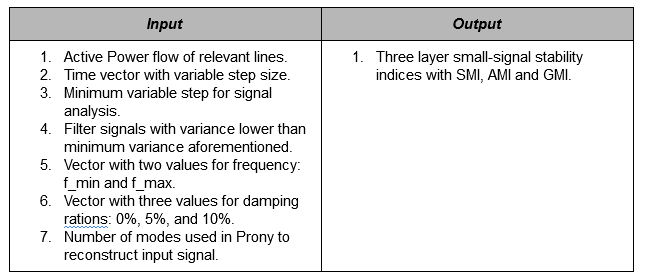

In [3]:
def sssi(signal,ts,stepsize_min,variance_min,Freq,Damp,Nm):
    
    import numpy as np
    import matplotlib.pyplot as plt
    import math
    import pandas as pd
    #from prony import pronyitesla
    #from test_filter import test_filter
    
    # %Small-signal-stability index (SSI) function 
    # %
    # %[ INDEX ] = sssi( signal,ts,step_min,var_min,F,D,Nm)
    # %
    # % OUTPUTS
    # %
    # %    INDEX - Three layer sss index with smi, ami and gmi.
    # %
    # % INPUTS
    # %   signal - Active power flow of relevant lines 
    # %       ts - Time vector with varable step size 
    # % step_min - Minimum varable step for signal analysis 
    # %  var_min - Filter signals with varianza lower than var_min
    # %       F  - [fmin,fmax] 1x2 vector with frequencies of interest in Hz
    # %       D  - [d0,d1,d2] 1x3 vector with damping ratios to compute index in
    # %                       percent
    # %       Nm - Number of modes used in Prony to reconstruc input signals
    # %
    # %
    # %    * Empty matrices will be delivered if input signals used are not
    # %      suitable for sss analysis
    
    yh,x,l,yhd = test_filter(signal,ts,variance_min,stepsize_min)
    
    if yhd.size == 0:
        out = np.array([])
        sss_smi = np.array([])
        sss_ami = np.array([])
        sss_gmi = np.array([])
        modelb = np.array([])
        detail_l = np.array([])
        detail_f = np.array([])
        detail_d = np.array([])
    else:
        t = yhd[:,0:1]
        y = yhd[:, (x.astype(int))+1]
        y = np.reshape(y,(len(y),len(y[0])))
        
        plt.figure(2)
        plt.plot(t,y)
        
        out_t = t
        out_y = y 
        
    
        fmin = Freq[0]
        fmax = Freq[1]
        dmax = 0.25
        
        sig = y[:,:]
        nL = len(sig[0])
        
        lamda, model_Poles, model_Res, model_K, model_that, model_yhat=pronyitesla(t,sig,Nm,(t[0])*np.ones([1,nL]),
                                                                                   t[len(t)-1]*np.ones([1,nL]), 0.1, 1, t[0], float(t[len(t)-1]), 1)
    
        
        dmodes0 = pd.DataFrame()
        
        Poles_sys = np.diag(lamda)   # number of modes
        n_modes1 = len(lamda)        
        fmodes0 = np.abs(np.imag(lamda))/(2*np.pi)     # frequency of modes in Hz
        #dmodes0 = -np.cos(math.atan2(np.imag(lamda),np.real(lamda)))
        
        for i in range(n_modes1):
            dmodes0.loc[i,0] = -np.cos(math.atan2(np.imag(lamda[i,0]),np.real(lamda[i,0])))
        
        dmodes0 = dmodes0.to_numpy()      # damping of modes
        
        fmodes1 = np.array(sorted(fmodes0))       # sorted modes  
        mode_idx1 = np.argsort(np.transpose(fmodes0))        # sorted modes
        
        dmodes1 = dmodes0[mode_idx1]   # sorted dampings
        
        jj = 0; kk = 0;
        
        fmodes2 = pd.DataFrame()
        dmodes2 = pd.DataFrame()
        mode_idx2 = pd.DataFrame()
        
        fmodes3 = pd.DataFrame()
        dmodes3 = pd.DataFrame()
        mode_idx3 = pd.DataFrame()
        
        for i in range(n_modes1):
            if (fmodes1[i,0] >= fmin) and (fmodes1[i,0] <= fmax):
                fmodes2.loc[jj,0] = fmodes1[i,0]
                dmodes2.loc[jj,0] = dmodes1[0,i,0]
                mode_idx2.loc[jj,0] = mode_idx1[0,i]
                if dmodes2.iloc[jj,0] <= dmax:
                    fmodes3.loc[kk,0] = fmodes2.iloc[jj,0]
                    dmodes3.loc[kk,0] = dmodes2.iloc[jj,0]
                    mode_idx3.loc[kk,0] = mode_idx2.iloc[jj,0]
                    kk = kk + 1
                jj = jj + 1
                
        fmodes2 = fmodes2.to_numpy()
        dmodes2 = dmodes2.to_numpy()
        mode_idx2 = mode_idx2.to_numpy()
        
        fmodes3 = fmodes3.to_numpy()
        dmodes3 = dmodes3.to_numpy()
        mode_idx3 = mode_idx3.astype(int).to_numpy()
        
        n_modes2 = len(fmodes3)
        jj = np.array(range(0,n_modes2,2)).reshape(-1,1)
        fmodes = fmodes3[jj]
        dmodes = dmodes3[jj,0]
        
        print('\n  f(Hz)        d(%)')
        print('---------------------')
        for i in range(int(n_modes2/2)):
            print('\n {:.4f}       {:.4f}'.format(float(fmodes[i]), float(dmodes[i]*100)))
        print('\n\n')
        
        detail_l = lamda[mode_idx3]
        detail_f = fmodes0[mode_idx3]
        detail_d = dmodes0[mode_idx3]
        
        
        th = pd.DataFrame()
        
        for i in range(len(Damp)):
            th.loc[0,i] = math.acos(Damp[i]/100)    
        th = th.to_numpy()
        ths = np.pi - th
        
        thl = pd.DataFrame()
        for i in range(len(dmodes)):
            thl.loc[i,0] = math.acos(dmodes[i,0])
        thl = thl.to_numpy()
        thls = np.pi - thl
        
        jj = 0;  kk = len(Damp);
        
        SMI = pd.DataFrame()
        
        for i in range(int(n_modes2/2)):
            for m in range(kk):
                SMI.loc[i,m] = thls[i,0] - ths[0,m]
                
        SMI = SMI.to_numpy()
        AMI = pd.DataFrame()
        
        for m in range(kk):
            AMI.loc[0,m] = np.min(SMI[:,m])
    
        AMI = AMI.to_numpy()
        
        GMI = np.min(AMI)
        
        sss_smi = SMI
        sss_ami = AMI
        sss_gmi = GMI
        
    return  sss_smi, sss_ami, sss_gmi, out_t, out_y, model_Poles, model_Res, model_K, model_that, model_yhat, detail_d, detail_f, detail_l

### Step 04 - Putting everything together

<br><i> Now that all the functions have been discussed, we can run an example. You can play around with two data sets to test the output of the sssi script.
<br>They are:
* 7bus_fault
* KYH_Nordic32_fault

In [4]:
import numpy as np
import scipy.io
import math
import matplotlib.pyplot as plt

#from test_filter import test_filter
#from sssi import sssi

#mat = scipy.io.loadmat('KTH_Nordic32_fault.mat')
mat = scipy.io.loadmat('7bus_fault.mat')

time = mat['ts']
signal = mat['P_line']

#a = 1
#b = 0.5
#time = np.linspace(0,10,100)
#signal = a*np.exp(-b*time)*np.cos(2*np.pi*60*time)
step_min = 0.04
var_min = 0.1
f = [0.1,2.5]
d = [0,5,10]
Nm = 10

# ----------------------------------------------------------------------------
# --------------------------- Original Signal Plot ---------------------------
# ----------------------------------------------------------------------------

plt.figure(1)
plt.plot(time,signal)
plt.xlabel('Time (sec)')
plt.ylabel('Intensity')
plt.title('Original Signal')


sss_smi, sss_ami, sss_gmi, out_t, out_y, model_Poles, model_Res, model_K, model_that, model_yhat, detail_d, detail_f, detail_l = sssi(signal, time, step_min, var_min, f, d, Nm)

print("Small Signal Stability SMI index: {}" .format(sss_smi))
print("Small Signal Stability AMI index: {}" .format(sss_ami))
print("Small Signal Stability GMI index: {}" .format(sss_gmi))

ModuleNotFoundError: No module named 'PyEMD'